# Analysis of `wandb` Logs and Metrics
This notebook collects different metrics for a specified experiment.

## Setup

In [1]:
import numpy as np
import pprint

import warnings

warnings.filterwarnings("ignore")

import wandb

api = wandb.Api()

In [2]:
runs = api.runs("uedyiuajxz-personal/qfl-prod-le-2")

In [3]:
groups = list(set(run.config.get("group", None) for run in runs))
print(groups)

['FHE-fedqnn-14166517', 'FHE-qcnn-14288056', 'Standard-resnet18-qnn-14288059', 'FHE-fedqnn-14096295', 'FHE-resnet18-qnn-14166523', 'FHE-fednn-14378195', 'FHE-resnet18-14385580', 'FHE-fedqnn-14378197', 'Standard-qcnn-14166518', 'FHE-resnet18-qnn-14096301', 'Standard-fednn-14288051', 'Standard-resnet18-14288057', 'Standard-fedqnn-14166516', 'Standard-fednn-14096292', 'Standard-resnet18-qnn-14166522', 'FHE-qcnn-14385578', 'Standard-resnet18-qcnn-14166524', 'FHE-resnet18-14096299', 'Standard-fedqnn-14288053', 'Standard-fedqnn-14378196', 'Standard-resnet18-qnn-14385581', 'FHE-resnet18-qnn-14385582', 'FHE-fednn-14166515', 'Standard-resnet18-qcnn-14096302', 'Standard-resnet18-qnn-14096300', 'Standard-resnet18-14166520', 'Standard-fednn-14378194', 'Standard-qcnn-14096296', 'FHE-resnet18-qnn-14288060', 'Standard-resnet18-qnn-14378202', 'Standard-resnet18-14096298', 'Standard-fedqnn-14096294', 'FHE-fednn-14385574', 'FHE-fedqnn-14288054', 'Standard-resnet18-14378200', 'FHE-qcnn-14166519', 'FHE-qc

In [4]:
group_in_focus = groups[0]

In [5]:
grouped_runs = [run for run in runs if run.config.get("group", None) == group_in_focus]
server = None
clients = []

for run in grouped_runs:
    participant = run.config.get("participant", None)
    if participant == "server":
        server = run
    else:
        clients.append(run)
    print(f"Run ID: {run.id}, Name: {run.name}, Type: {participant}")

Run ID: hn17adh6, Name: server, Type: server
Run ID: 3ftktvf6, Name: client19, Type: client19
Run ID: 6cp3svm0, Name: client15, Type: client15
Run ID: 9jbca52f, Name: client16, Type: client16
Run ID: a02if3fj, Name: client13, Type: client13
Run ID: cul6a9sy, Name: client2, Type: client2
Run ID: cz0zz3ht, Name: client1, Type: client1
Run ID: eo4dxy5p, Name: client14, Type: client14
Run ID: jwwypcql, Name: client3, Type: client3
Run ID: nwwruezv, Name: client0, Type: client0
Run ID: oy7ji7ye, Name: client18, Type: client18
Run ID: qcxyi1qk, Name: client6, Type: client6
Run ID: vrv71j6o, Name: client9, Type: client9
Run ID: w567y2ln, Name: client7, Type: client7
Run ID: wvg54wb4, Name: client8, Type: client8
Run ID: xs4m0ur3, Name: client4, Type: client4
Run ID: zcn2hp4f, Name: client10, Type: client10
Run ID: 9bifxors, Name: client12, Type: client12
Run ID: rxcz5ahv, Name: client17, Type: client17
Run ID: p8747lhq, Name: client5, Type: client5
Run ID: ump46xlq, Name: client11, Type: clie

## Settings

In [6]:
pp = pprint.PrettyPrinter(indent=1, width=40)
pp.pprint(server.config)

{'batch_size': 32,
 'dataset': 'MRI',
 'fhe_enabled': True,
 'group': 'FHE-fedqnn-14166517',
 'learning_rate': '1e-3',
 'model': 'fedqnn',
 'number_clients': 20,
 'participant': 'server',
 'rounds': 20}


## Server and Aggregated Metrics

In [7]:
def compute_statistics(arr: np.ndarray) -> dict:
    """
    Compute basic statistical measures of an array, including mean, median, standard deviation,
    25th percentile (Q1), and 75th percentile (Q3).

    Parameters
    ----------
    arr : np.ndarray
        Input numerical array.

    Returns
    -------
    dict
        A dictionary containing the following statistics:
        - "mean" : float
            The average of the array.
        - "median" : float
            The middle value of the array.
        - "std" : float
            The standard deviation (sample standard deviation with `ddof=1`).
        - "25%" : float
            The 25th percentile (Q1).
        - "75%" : float
            The 75th percentile (Q3).

    Examples
    --------
    >>> import numpy as np
    >>> data = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    >>> compute_statistics(data)
    {'mean': 55.0, 'median': 55.0, 'std': 30.276503540974915, '25%': 32.5, '75%': 77.5}
    """
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)

    stats = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std": np.std(arr, ddof=1),
        "25%": np.percentile(arr, 25),
        "75%": np.percentile(arr, 75),
        "min": np.min(arr),
        "max": np.max(arr),
        "last_value": arr[-1],
    }
    return stats

In [8]:
from rich.console import Console
from rich.table import Table

console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Server Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Server Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

server_history = server.history()
for metric in server_history.keys():
    metric_values = [val for val in server_history[metric] if not np.isnan(val)]
    stats = compute_statistics(metric_values)

    # Add row to Table 1
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )


console.print(table1)
console.print(table2)

                            Server Statistics (Part 1)                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric                     ┃            Mean ┃          Median ┃            Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ _step                      │           10.50 │           10.50 │           6.49 │
│ _runtime                   │         9957.52 │         9989.84 │        6097.17 │
│ trainable_parameters       │         2112.00 │         2112.00 │            nan │
│ _timestamp                 │   1747866247.87 │   1747866280.19 │        6097.16 │
│ loss_agg                   │            0.94 │            0.91 │           0.12 │
│ round                      │           10.50 │           10.50 │           5.92 │
│ Bytes Received (Round)     │  14119853317.55 │  14119855685.00 │       40988.25 │
│ Total Bytes Received       │ 148258479782.30 │ 148258539472.00 │ 83534190027.57 │
│ parameter_aggregation_time │           58.27 │           58.72 │           0.99 │
│ metrics_agg.accuracy       │           60.16 │           60.54 │           4.73 │
│ metrics_agg.precisions     │            0.60 │            0.61 │           0.05 │
│ round_time                 │          873.42 │          875.00 │           6.15 │
│ metrics_agg.f1s            │            0.60 │            0.61 │           0.05 │
│ metrics_agg.recalls        │            0.60 │            0.61 │           0.05 │
│ Total Bytes Sent           │   2632490071.50 │   2632490071.50 │  1639364432.29 │
│ Bytes Sent (Round)         │    263248506.95 │    277103165.00 │    61959914.41 │
│ total_training_time        │        19030.58 │        19030.58 │            nan │
└────────────────────────────┴─────────────────┴─────────────────┴────────────────┘

                                            Server Statistics (Part 2)                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric                  ┃            25% ┃             75% ┃             Max ┃            Min ┃            Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ _step                   │           5.25 │           15.75 │           21.00 │           0.00 │           21.00 │
│ _runtime                │        5009.77 │        14983.81 │        19033.18 │           2.51 │        19033.18 │
│ trainable_parameters    │        2112.00 │         2112.00 │         2112.00 │        2112.00 │         2112.00 │
│ _timestamp              │  1747861300.13 │   1747871274.17 │   1747875323.43 │  1747856292.82 │   1747875323.43 │
│ loss_agg                │           0.87 │            0.95 │            1.33 │           0.83 │            0.83 │
│ round                   │           5.75 │           15.25 │           20.00 │           1.00 │           20.00 │
│ Bytes Received (Round)  │ 14119827203.50 │  14119873287.75 │  14119926197.00 │ 14119775886.00 │  14119826284.00 │
│ Total Bytes Received    │ 81189206260.50 │ 215327783884.00 │ 282397066351.00 │ 14119832911.00 │ 282397066351.00 │
│ parameter_aggregation_… │          57.13 │           58.97 │           60.14 │          56.83 │           56.83 │
│ metrics_agg.accuracy    │          59.99 │           62.77 │           65.79 │          42.44 │           65.79 │
│ metrics_agg.precisions  │           0.60 │            0.63 │            0.66 │           0.42 │            0.66 │
│ round_time              │         872.63 │          876.52 │          882.77 │         856.02 │          876.10 │
│ metrics_agg.f1s         │           0.60 │            0.63 │            0.66 │           0.42 │            0.66 │
│ metrics_agg.recalls     │           0.60 │            0.63 │            0.66 │           0.42 │            0.66 │
│ Total Bytes Sent        │  1316250037.75 │   3948730105.25 │   5264970139.00 │       10004.00 │   5264970139.00 │
│ Bytes Sent (Round)      │   277103165.00 │    277103165.00 │    277103165.00 │       10004.00 │    277103165.00 │
│ total_training_time     │       19030.58 │        19030.58 │        19030.58 │       19030.58 │        19030.58 │
└─────────────────────────┴────────────────┴─────────────────┴─────────────────┴────────────────┴─────────────────┘

## Client Metrics

In [9]:
def compute_client_statistics(client_histories):
    """
    Computes statistics for each metric by merging values across all clients.

    Parameters
    ----------
    client_histories : list[dict]
        A list of dictionaries where each dictionary contains metric history for a single client.

    Returns
    -------
    dict
        A dictionary where each key is a metric name and the value is its computed statistics.
    """
    merged_metrics = {}

    # Iterate through all client histories
    for client_history in client_histories:
        for metric, values in client_history.items():
            # Remove NaN values and flatten lists
            cleaned_values = [val for val in values if not np.isnan(val)]

            # Merge values from all clients
            if metric not in merged_metrics:
                merged_metrics[metric] = []
            merged_metrics[metric].extend(cleaned_values)

    # Compute statistics for each metric
    stats_dict = {
        metric: compute_statistics(np.array(values))
        for metric, values in merged_metrics.items()
    }

    return stats_dict


# Example: Fetch history from multiple clients
client_histories = [
    client.history() for client in clients
]  # Replace with actual client list

# Compute merged statistics
merged_stats = compute_client_statistics(client_histories)

# Display results using rich
console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Merged Client Metrics Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Merged Client Metrics Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

# Populate table with computed statistics
for metric, stats in merged_stats.items():
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )

# Display table
console.print(table1)
console.print(table2)

                 Merged Client Metrics Statistics (Part 1)                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                   ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ _step                    │      10447.95 │       3319.50 │     12486.37 │
│ _runtime                 │       4698.21 │         35.31 │      6392.39 │
│ decryption_time          │          1.46 │          1.54 │         0.33 │
│ _timestamp               │ 1747871036.85 │ 1747875401.98 │      6160.99 │
│ client_round_time        │        823.02 │        830.53 │        33.11 │
│ encryption_time          │          1.80 │          1.47 │         1.08 │
│ server_virtual_memory_mb │      64185.51 │      66033.19 │     12639.09 │
│ client_real_memory_mb    │       3918.40 │       3942.26 │       745.28 │
│ client_cpu_percentage    │        203.77 │        161.80 │       170.80 │
│ server_real_memory_mb    │      50325.55 │      52004.06 │     11720.24 │
│ client_virtual_memory_mb │      16035.32 │      16246.31 │      1564.02 │
│ server_cpu_percentage    │         20.96 │          0.00 │       145.39 │
└──────────────────────────┴───────────────┴───────────────┴──────────────┘

                                 Merged Client Metrics Statistics (Part 2)                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                   ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ _step                    │         11.00 │      20764.00 │      38172.00 │          0.00 │      38172.00 │
│ _runtime                 │         18.29 │       9350.66 │      18986.47 │          1.14 │         37.99 │
│ decryption_time          │          1.44 │          1.60 │          2.02 │          0.05 │          1.49 │
│ _timestamp               │ 1747866761.47 │ 1747875418.88 │ 1747875435.71 │ 1747856343.68 │ 1747875435.71 │
│ client_round_time        │        806.46 │        849.00 │        870.61 │        703.02 │        825.16 │
│ encryption_time          │          1.09 │          2.12 │          8.51 │          0.75 │          1.47 │
│ server_virtual_memory_mb │      65929.22 │      66091.04 │      78821.16 │       4562.07 │      53555.49 │
│ client_real_memory_mb    │       3894.70 │       4025.39 │       5930.06 │        433.35 │       5930.06 │
│ client_cpu_percentage    │         75.65 │        309.68 │        840.30 │          0.00 │         45.90 │
│ server_real_memory_mb    │      51942.75 │      52065.86 │      64837.02 │        260.21 │      39658.39 │
│ client_virtual_memory_mb │      16199.15 │      16315.91 │      18220.90 │       4697.41 │      18220.90 │
│ server_cpu_percentage    │          0.00 │          0.00 │       1540.20 │          0.00 │          0.00 │
└──────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Other Computations

In [10]:
some_client = clients[0]
history = some_client.history()
metric_values = [val for val in history["client_round_time"] if not np.isnan(val)]
sum(metric_values)

16983.794940710068

# Settings


In [90]:
COLOR = "#A9A9A9"
KEY_ORDER = [
    "Standard-fednn",
    "FHE-fednn",
    "Standard-fedqnn",
    "FHE-fedqnn",
    "Standard-qcnn",
    "FHE-qcnn",
    "Standard-resnet18",
    "FHE-resnet18",
    "Standard-resnet18-qnn",
    "FHE-resnet18-qnn",
    "Standard-resnet18-qcnn",
]

## Training Time

In [16]:
training_times = {}

for group in groups:
    try:
        print(f"Checking group {group}")
        grouped_runs = [run for run in runs if run.config.get("group", None) == group]
        server = None
        for run in grouped_runs:
            participant = run.config.get("participant", None)
            if participant == "server":
                server = run
                break
        server_history = server.history()
        metric_values = [
            val for val in server_history["total_training_time"] if not np.isnan(val)
        ]
        model = "-".join(group.split("-")[:-1])
        if model in training_times.keys():
            training_times[model] = training_times[model] + metric_values
        else:
            training_times[model] = metric_values
    except KeyError:
        print("Somehow parameter was not found for current group.")
        continue

Checking group FHE-fedqnn-14166517
Checking group FHE-qcnn-14288056
Checking group Standard-resnet18-qnn-14288059
Checking group FHE-fedqnn-14096295
Checking group FHE-resnet18-qnn-14166523
Checking group FHE-fednn-14378195
Checking group FHE-resnet18-14385580
Checking group FHE-fedqnn-14378197
Checking group Standard-qcnn-14166518
Checking group FHE-resnet18-qnn-14096301
Checking group Standard-fednn-14288051
Checking group Standard-resnet18-14288057
Checking group Standard-fedqnn-14166516
Checking group Standard-fednn-14096292
Checking group Standard-resnet18-qnn-14166522
Checking group FHE-qcnn-14385578
Checking group Standard-resnet18-qcnn-14166524
Checking group FHE-resnet18-14096299
Checking group Standard-fedqnn-14288053
Checking group Standard-fedqnn-14378196
Checking group Standard-resnet18-qnn-14385581
Checking group FHE-resnet18-qnn-14385582
Checking group FHE-fednn-14166515
Checking group Standard-resnet18-qcnn-14096302
Checking group Standard-resnet18-qnn-14096300
Checking

In [101]:
training_times = {k: training_times[k] for k in KEY_ORDER}

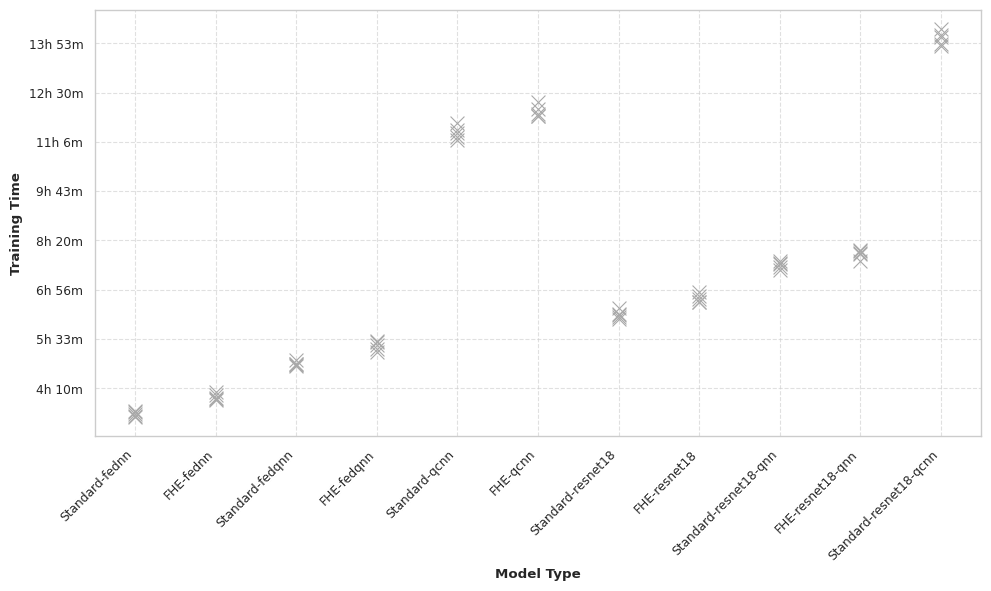

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid", context="paper")


def format_time(seconds, _):
    if seconds < 60:
        return f"{int(seconds)}s"
    elif seconds < 3600:
        minutes = seconds // 60
        seconds = seconds % 60
        return f"{int(minutes)}m {int(seconds)}s"
    else:
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        return f"{int(hours)}h {int(minutes)}m"


# Setting up the plot with Seaborn
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each model's training times using Seaborn's enhancements
for model, times in training_times.items():
    sns.scatterplot(
        x=[model] * len(times),
        y=times,
        ax=ax,
        label=model,
        s=100,
        marker="x",
        color=COLOR,
    )

# Customize the plot
plt.xticks(rotation=45, ha="right")
plt.xlabel("Model Type", fontweight="bold")
plt.ylabel("Training Time", fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
ax.yaxis.set_major_formatter(FuncFormatter(format_time))

# Enhance legend styling
plt.tight_layout()

if ax.get_legend() is not None:
    ax.get_legend().remove()

# Show and save plot
plt.show()

In [102]:
for model in training_times.keys():
    print(f"Stats for {model}")
    print(f"Mean: {int(np.mean(training_times[model]) / 60)} minutes")
    print(f"Median: {int(np.median(training_times[model]) / 60)} minutes")
    print(f"Min: {int(np.min(training_times[model]) / 60)} minutes")
    print(f"Max: {int(np.max(training_times[model]) / 60)} minutes")
    print(f"Std: {int(np.std(training_times[model], ddof=1) / 60)} minutes")
    print(f"25%: {int(np.percentile(training_times[model], 25) / 60)} minutes")
    print(f"75%: {int(np.percentile(training_times[model], 75) / 60)} minutes")

Stats for Standard-fednn
Mean: 206 minutes
Median: 206 minutes
Min: 201 minutes
Max: 211 minutes
Std: 4 minutes
25%: 202 minutes
75%: 210 minutes
Stats for FHE-fednn
Mean: 235 minutes
Median: 234 minutes
Min: 230 minutes
Max: 244 minutes
Std: 5 minutes
25%: 232 minutes
75%: 238 minutes
Stats for Standard-fedqnn
Mean: 291 minutes
Median: 290 minutes
Min: 288 minutes
Max: 298 minutes
Std: 3 minutes
25%: 290 minutes
75%: 291 minutes
Stats for FHE-fedqnn
Mean: 321 minutes
Median: 322 minutes
Min: 311 minutes
Max: 329 minutes
Std: 7 minutes
25%: 317 minutes
75%: 327 minutes
Stats for Standard-qcnn
Mean: 682 minutes
Median: 682 minutes
Min: 669 minutes
Max: 699 minutes
Std: 11 minutes
25%: 674 minutes
75%: 686 minutes
Stats for FHE-qcnn
Mean: 718 minutes
Median: 714 minutes
Min: 709 minutes
Max: 733 minutes
Std: 9 minutes
25%: 711 minutes
75%: 721 minutes
Stats for Standard-resnet18
Mean: 374 minutes
Median: 374 minutes
Min: 367 minutes
Max: 385 minutes
Std: 6 minutes
25%: 370 minutes
75%: 3

# CPU Usage

In [ ]:
client_cpu_usage = {}

for group in groups:
    try:
        print(f"Checking group {group}")
        grouped_runs = [run for run in runs if run.config.get("group", None) == group]
        model = "-".join(group.split("-")[:-1])
        for run in grouped_runs:
            if run.name != "system_logs":
                continue
            system_client = run.history()
            metric_values = [
                val
                for val in system_client["client_cpu_percentage"]
                if not np.isnan(val)
            ]
            if model in client_cpu_usage.keys():
                client_cpu_usage[model] = client_cpu_usage[model] + metric_values
            else:
                client_cpu_usage[model] = metric_values
    except KeyError:
        print("Somehow parameter was not found for current group.")
        continue

Checking group FHE-fedqnn-14166517
Checking group FHE-qcnn-14288056
Checking group Standard-resnet18-qnn-14288059
Checking group FHE-fedqnn-14096295
Checking group FHE-resnet18-qnn-14166523
Checking group FHE-fednn-14378195
Checking group FHE-resnet18-14385580
Checking group FHE-fedqnn-14378197
Checking group Standard-qcnn-14166518
Checking group FHE-resnet18-qnn-14096301
Checking group Standard-fednn-14288051
Checking group Standard-resnet18-14288057
Checking group Standard-fedqnn-14166516
Checking group Standard-fednn-14096292
Checking group Standard-resnet18-qnn-14166522
Checking group FHE-qcnn-14385578
Checking group Standard-resnet18-qcnn-14166524
Checking group FHE-resnet18-14096299
Checking group Standard-fedqnn-14288053
Checking group Standard-fedqnn-14378196
Checking group Standard-resnet18-qnn-14385581
Checking group FHE-resnet18-qnn-14385582
Checking group FHE-fednn-14166515
Checking group Standard-resnet18-qcnn-14096302
Checking group Standard-resnet18-qnn-14096300
Checking

In [ ]:
client_cpu_usage = {k: client_cpu_usage[k] for k in KEY_ORDER}

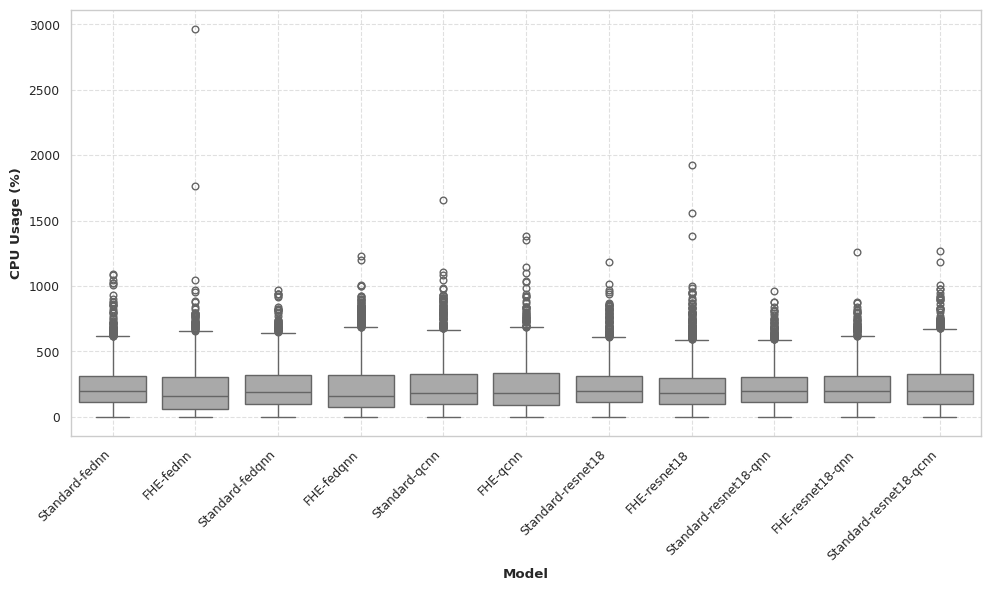

In [93]:
data = []
for client, usages in client_cpu_usage.items():
    for usage in usages:
        data.append({"Model": client, "CPU Usage": usage})

# Use Pandas to create a DataFrame from the data list
import pandas as pd

df = pd.DataFrame(data)

# Set up the visual with Seaborn
sns.set_theme(style="whitegrid", context="paper")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Model", y="CPU Usage", data=df, color=COLOR)

# Customize aesthetics
plt.xticks(rotation=45, ha="right")
plt.xlabel("Model", fontweight="bold")
plt.ylabel("CPU Usage (%)", fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

In [80]:
df.groupby("Model").describe()

CPU Usage                                             \
                           count        mean         std  min    25%    50%   
Model                                                                         
FHE-fednn                 2435.0  196.437659  185.960776  0.0   61.9  155.7   
FHE-fedqnn                2464.0  214.902922  197.086035  0.0   73.9  155.8   
FHE-qcnn                  2498.0  228.954924  182.128249  0.0   93.9  183.8   
FHE-resnet18              2488.0  218.470257  177.470239  0.0   99.7  181.8   
FHE-resnet18-qnn          2494.0  226.424940  157.676044  0.0  109.9  197.8   
Standard-fednn            2450.0  227.593388  158.442673  0.0  111.8  199.8   
Standard-fedqnn           2485.0  220.764789  163.231011  0.0   97.9  187.8   
Standard-qcnn             2482.0  230.744400  187.089100  0.0   97.9  179.8   
Standard-resnet18         2498.0  227.913531  166.429252  0.0  109.9  199.8   
Standard-resnet18-qcnn    2496.0  236.238261  176.149272  0.0   99.9  197.8   
Standard-resnet18-qnn     2497.0  227.315258  147.847357  0.0  115.9  197.8   

                                         
                            75%     max  
Model                                    
FHE-fednn               300.650  2962.8  
FHE-fedqnn              317.700  1229.4  
FHE-qcnn                331.575  1384.0  
FHE-resnet18            295.700  1927.9  
FHE-resnet18-qnn        313.700  1262.7  
Standard-fednn          313.700  1092.9  
Standard-fedqnn         317.700   973.0  
Standard-qcnn           327.700  1656.6  
Standard-resnet18       309.700  1184.9  
Standard-resnet18-qcnn  329.700  1264.7  
Standard-resnet18-qnn   305.700   959.0

# RAM Usage

In [ ]:
client_ram_usage = {}

for group in groups:
    try:
        print(f"Checking group {group}")
        grouped_runs = [run for run in runs if run.config.get("group", None) == group]
        model = "-".join(group.split("-")[:-1])
        for run in grouped_runs:
            if run.name != "system_logs":
                continue
            system_client = run.history()
            metric_values = [
                val
                for val in system_client["client_virtual_memory_mb"]
                if not np.isnan(val)
            ]
            if model in client_ram_usage.keys():
                client_ram_usage[model] = client_ram_usage[model] + metric_values
            else:
                client_ram_usage[model] = metric_values
    except KeyError:
        print("Somehow parameter was not found for current group.")
        continue

client_ram_usage = {k: client_ram_usage[k] for k in KEY_ORDER}

Checking group FHE-fedqnn-14166517
Checking group FHE-qcnn-14288056
Checking group Standard-resnet18-qnn-14288059
Checking group FHE-fedqnn-14096295
Checking group FHE-resnet18-qnn-14166523
Checking group FHE-fednn-14378195
Checking group FHE-resnet18-14385580
Checking group FHE-fedqnn-14378197
Checking group Standard-qcnn-14166518
Checking group FHE-resnet18-qnn-14096301
Checking group Standard-fednn-14288051
Checking group Standard-resnet18-14288057
Checking group Standard-fedqnn-14166516
Checking group Standard-fednn-14096292
Checking group Standard-resnet18-qnn-14166522
Checking group FHE-qcnn-14385578
Checking group Standard-resnet18-qcnn-14166524
Checking group FHE-resnet18-14096299
Checking group Standard-fedqnn-14288053
Checking group Standard-fedqnn-14378196
Checking group Standard-resnet18-qnn-14385581
Checking group FHE-resnet18-qnn-14385582
Checking group FHE-fednn-14166515
Checking group Standard-resnet18-qcnn-14096302
Checking group Standard-resnet18-qnn-14096300
Checking

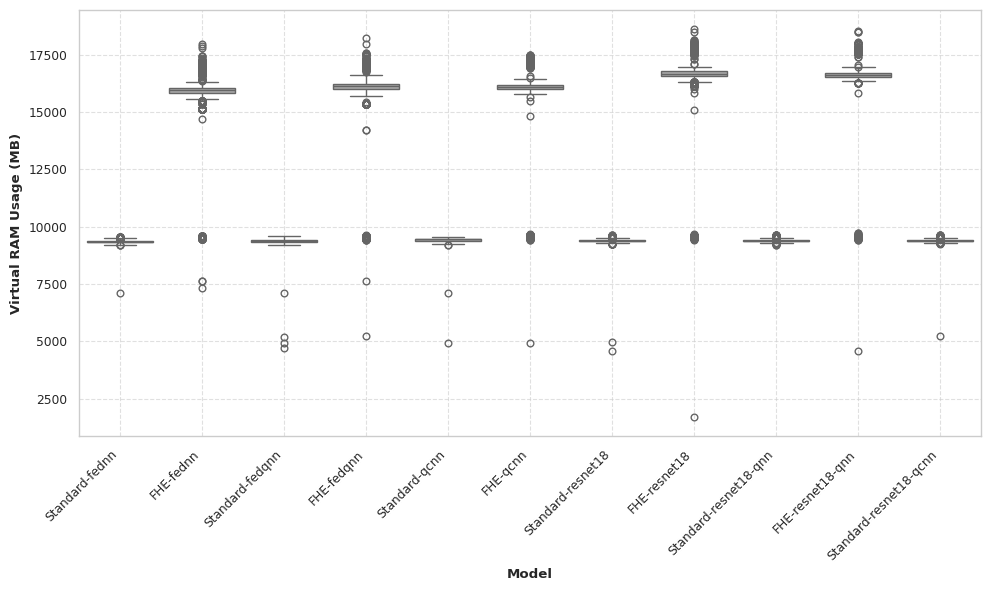

In [94]:
data = []
for client, usages in client_ram_usage.items():
    for usage in usages:
        data.append({"Model": client, "Virtual RAM Usage": usage})

# Use Pandas to create a DataFrame from the data list
import pandas as pd

df = pd.DataFrame(data)

# Set up the visual with Seaborn
sns.set_theme(style="whitegrid", context="paper")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Model", y="Virtual RAM Usage", data=df, color=COLOR)

# Customize aesthetics
plt.xticks(rotation=45, ha="right")
plt.xlabel("Model", fontweight="bold")
plt.ylabel("Virtual RAM Usage (MB)", fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

In [95]:
df.groupby("Model").describe()

Virtual RAM Usage                                       \
                                   count          mean          std       min   
Model                                                                           
FHE-fednn                         2430.0  15801.356214  1326.922189  7307.566   
FHE-fedqnn                        2474.0  15939.751369  1386.232065  5237.250   
FHE-qcnn                          2494.0  15822.956265  1474.684205  4945.809   
FHE-resnet18                      2487.0  16373.091247  1643.764098  1706.191   
FHE-resnet18-qnn                  2497.0  16402.059361  1446.791715  4576.656   
Standard-fednn                    2446.0   9358.580061    73.499363  7088.770   
Standard-fedqnn                   2491.0   9371.795425   172.783685  4695.832   
Standard-qcnn                     2482.0   9427.558977   119.387380  4913.430   
Standard-resnet18                 2497.0   9391.205981   141.346356  4594.379   
Standard-resnet18-qcnn            2499.0   9392.612088    94.466766  5239.379   
Standard-resnet18-qnn             2495.0   9392.766802    52.563661  9192.156   

                                                                       
                               25%         50%         75%        max  
Model                                                                  
FHE-fednn               15843.1720  15943.0510  16034.7770  17967.926  
FHE-fedqnn              15980.0225  16126.0430  16239.2600  18218.152  
FHE-qcnn                15989.8090  16091.0120  16187.5430  17484.297  
FHE-resnet18            16585.0200  16648.4380  16766.4920  18610.441  
FHE-resnet18-qnn        16543.6370  16601.9180  16705.4880  18518.488  
Standard-fednn           9317.9045   9349.3045   9387.2070   9547.367  
Standard-fedqnn          9327.2010   9368.2230   9433.1330   9572.805  
Standard-qcnn            9381.0590   9449.6880   9479.7030   9564.051  
Standard-resnet18        9358.4770   9388.8440   9421.3010   9639.980  
Standard-resnet18-qcnn   9366.3520   9392.0590   9413.0585   9627.055  
Standard-resnet18-qnn    9357.9355   9389.5430   9415.1445   9638.730